In [1]:
#Библиотеки для работы с данными
import numpy as np
import pandas as pd
import itertools
import csv
from natsort import natsort_keygen
#Для построения и работы с графиками
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
#Для работы с моделями
import keras
import tensorflow as tf
import sklearn
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#Для оценки результатов обучения модели
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from livelossplot.tf_keras import PlotLossesCallback
#Контроль над скоростью обучения
from keras.callbacks import ReduceLROnPlateau
#Для работы с изображениями
import cv2
from PIL import Image

2024-09-06 14:24:47.465425: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Подтянем директории с файлами для обучения
#Тренировочная часть
train_dir = './data/emotion_recog_data/train'
#Публичная тестовая часть датасета
test_dir = './data/emotion_recog_data/test'

In [3]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input

BATCH_SIZE = 100
IMG_SHAPE  = 224


#Обучение и валидация:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, preprocessing_function=preprocess_input)

#Тестирование результатов (здесь нужно применить только rescale и preprocess):
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_input)

#Теперь сгенерируем датасет на основе заданных ранее параметров:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_SHAPE ,IMG_SHAPE),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = val_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_SHAPE ,IMG_SHAPE),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = './data/emotion_recog_data/',
                                                    target_size = (IMG_SHAPE ,IMG_SHAPE),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    seed = 12,
                                                    classes=['test']
                                                  )

Found 40040 images belonging to 9 classes.
Found 10007 images belonging to 9 classes.
Found 5000 images belonging to 1 classes.


## Model evaluation

In [4]:
#Загрузим модель из чекпойнта
model = tf.keras.models.load_model("checkpoints/emotion_recog/best_model.h5")

2024-09-06 14:24:53.049124: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-06 14:24:53.070594: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-06 14:24:53.070635: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-06 14:24:53.071892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-06 14:24:53.071923: I tensorflow/compile

In [5]:
#Проверим, выведя структуру модели
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 9)                 297       
                                                                 
Total params: 36420617 (138.93 MB)
Trainable params: 128

In [6]:
#Проверка текущих результатов:
model.evaluate(validation_generator)

2024-09-06 14:24:55.232562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-09-06 14:24:55.845164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


101/101 [==============================] - 24s 216ms/step - loss: 1.9057 - categorical_accuracy: 0.3055


[1.9056652784347534, 0.30548617243766785]

Детальнее посмотрим на результаты нашей модели. Начнем с того, что выведем предсказание по случайному батчу из валидационного сета:

In [7]:
#Для этого напишем функцию, выведем несколько изображений и их предсказания, а также правильные ярлыки на экран:
def show_images_preds(images, labels, predicted_labels=None):
    names = dict((v,k) for k,v in train_generator.class_indices.items()) #подтянем названия классов по их нумерации в датагене
    plt.figure(figsize=(12,12))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=10)
    #Выведем 9 изображений по 3 в каждом ряду:
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = images[i]
        #Нормализация цвета для текущего изображения:
        img = ((img-img.min()) / (img.max()- img.min())) * 255
        img = Image.fromarray(img.astype(np.uint8))
        plt.imshow(img)
        #Настройка отображения ярлыков
        if predicted_labels is not None:
            real_label = labels[i].argmax()
            title_obj = plt.title(f"Real: {names[real_label]}. Pred: {names[predicted_labels[i]]}")
            #Если предсказанный ярлык не совпадает с фактическим, цвет текста поменяем на красный:
            if real_label != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

4/4 [==============================] - 2s 191ms/step


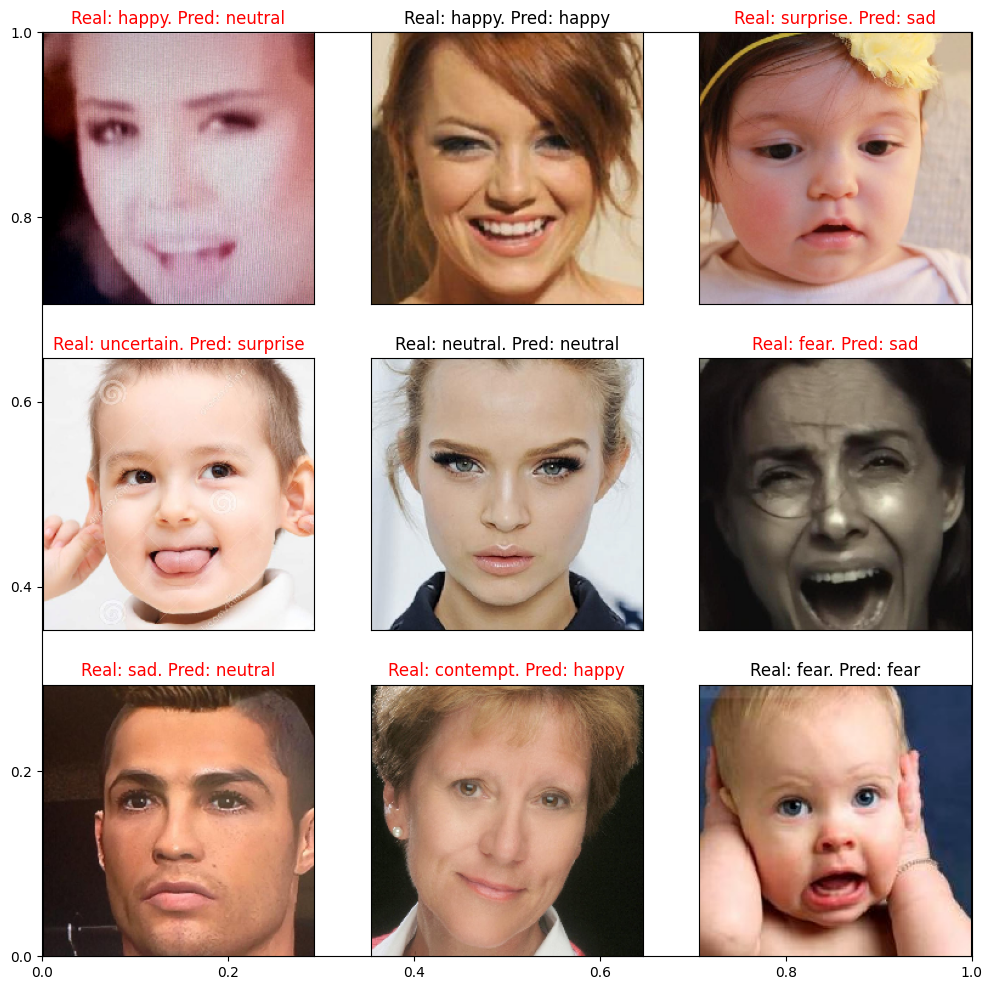

In [8]:
#Опробуем на случайном батче
sample_validation_images, sample_validation_labels = validation_generator[24]
predicted = model.predict(sample_validation_images).argmax(axis=1)
show_images_preds(sample_validation_images, sample_validation_labels, predicted)

In [9]:
# Также выведем так называемую матрицу ошибок, чтобы детальнее оценить масштабы бедствия/успеха:
preds = model.predict(validation_generator)
y_pred = np.argmax(preds , axis = 1 )
y_test = np.array(validation_generator.labels)

101/101 [==============================] - 22s 216ms/step


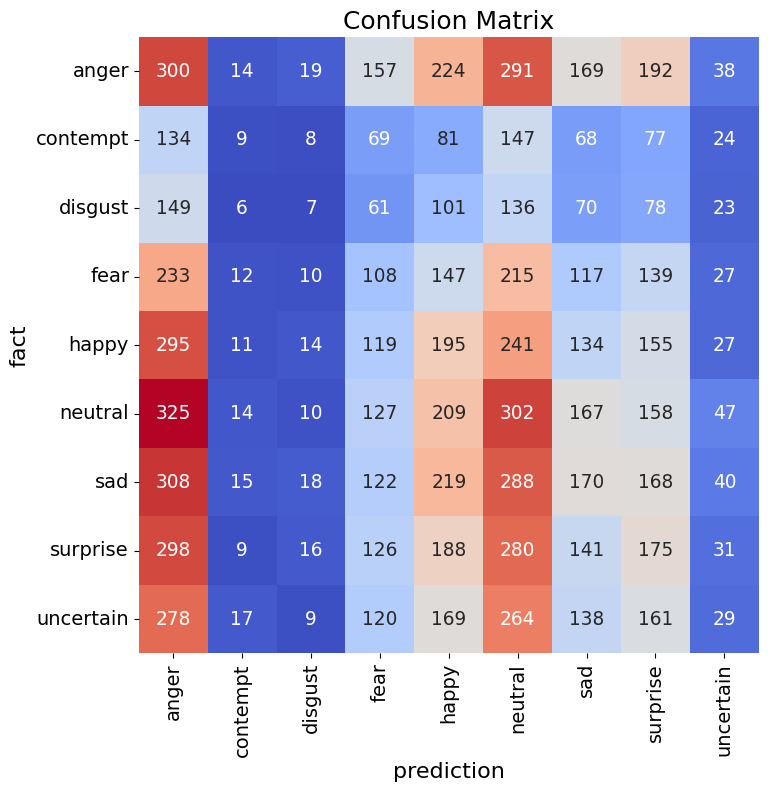

In [10]:
#Функция для отображения матрицы ошибок
def show_conf_matrix(y_test, y_pred, subset=None, cmap = "coolwarm", figsize = (8,8)):
    if subset is not None:
        cm_data = confusion_matrix(y_test , y_pred, labels=subset)
        names = dict((v,k) for k,v in train_generator.class_indices.items())
        cm_labels = [names[i] for i in subset]
    else:
        cm_labels = list(train_generator.class_indices.keys())
        cm_data = confusion_matrix(y_test , y_pred)
    
    cm = pd.DataFrame(cm_data, columns=cm_labels, index = cm_labels)
    cm.index.name = 'fact'
    cm.columns.name = 'prediction'
    plt.figure(figsize = figsize)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel('fact', fontsize=16)
    plt.ylabel('prediction', fontsize=16)
    plt.title('Confusion Matrix', fontsize = 18)
    ax = sns.heatmap(cm, cbar=False, cmap = cmap, annot=True, fmt='g', cbar_kws={'label': 'Scale'}, annot_kws={"size":40 / np.sqrt(len(cm))})
    
show_conf_matrix(y_test, y_pred)

Пришлось немного поиграться с цветами, чтобы отобразить такое большое количество объектов в более читаемом виде. В итоге было придумано следующее - чем теплее цвет, тем больше объектов было отнесено к данной категории, чем холоднее - тем меньше. Так становится чуть заметнее, что на точность модели всё-таки значительно влияет несбалансированность количества изображений по классам. Из=за этого модель более склонна относить изображение к классам "гнев (anger)" и "нейтральный (neutral)" и намного меньше - к классам "презрение (contempt)", "отвращение (disgust)","неопределённость (uncertain)".

Посмотрим на матрицу для эмоций гнев и нейтральная отдельно, чтобы оценить насколько хорошо модель определяет предсказания для наиболее "доминирующих" классов:

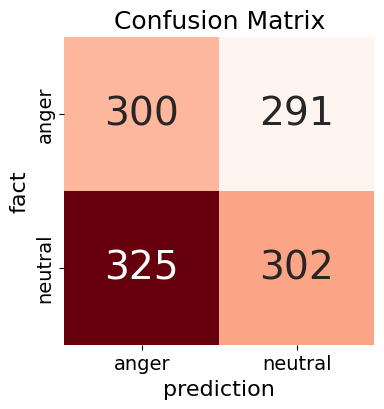

In [11]:
subset_labels = [0,5]
show_conf_matrix(y_test, y_pred, subset_labels, cmap = 'Reds', figsize = (4,4))

Можно сказать, что с задачей определения этих эмоций модель уже справляется сравнительно неплохо, хотя до идеала еще очень далеко.

In [12]:
#Наконец, посмотрим на classification report по модели:
names = list(train_generator.class_indices.keys())
print(classification_report(y_test, y_pred, target_names=names))

              precision    recall  f1-score   support

       anger       0.13      0.21      0.16      1404
    contempt       0.08      0.01      0.02       617
     disgust       0.06      0.01      0.02       631
        fear       0.11      0.11      0.11      1008
       happy       0.13      0.16      0.14      1191
     neutral       0.14      0.22      0.17      1359
         sad       0.14      0.13      0.13      1348
    surprise       0.13      0.14      0.14      1264
   uncertain       0.10      0.02      0.04      1185

    accuracy                           0.13     10007
   macro avg       0.11      0.11      0.10     10007
weighted avg       0.12      0.13      0.12     10007



Classification report подтвердил уже сделанные ранее выводы про несбалансированность обучающих данных.

Изменение весов вслепую методом compute_class_weight бибилиотеки sklearn не принесло желательного результата. Прошерстив еще нменого литературы, я пришла к выводу, что имеет смысл дообучить нашу модель с учетом другой метрики - f1-score, т.к. она учитывает сразу precision и recall, а также чаще рекомендуется для задач классификации в целом и для задач классификации несбалансированных наборов данных в частности.

In [13]:
#Далее, посмотрим на все слои базовой модели resnet, чтобы понять с какого слоя следует начать дообучение:
for i,layer in enumerate(model.layers[0].layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_block

In [14]:
# Разморозим последние 2 conv блока в нашей модели (слой 166 и дальше):
for layer in model.layers[0].layers[:166]:
    layer.trainable = False
for layer in model.layers[0].layers[166:]:
    layer.trainable = True

In [15]:
# Проверка статуса:
for i, layer in enumerate(model.layers[0].layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

### Fine tuning

F1 score в качестве метрики для мониторинга оказалось не совсем просто реализовать на практике.

Для этого пришлось скачивать старую библиотеку tensorflow_addons, чтобы модель не ругалась на форму ввода.

Другие варианты  решения проблемы предполагали самостоятельную реализацию функции для данной метрики, что мне показалось не совсем разумным, учитывая что существует вполне себе рабочий вариант.

Для работы метрики с множественной (небинарной) классификацией необходимо, помимо прочего, указать метод усреднения показателей. Мы укажем метод качестве такого метода "weighted" -функция вычисляет f1 для каждой метки класса и возвращает среднее значение с учетом доли каждого класса в наборе данных (или так называемой "поддержки" класса, англ. - "support").

*Примечание: Усреднение "macro" (простое взвешенное), к сожалению, показывает чуть менее удачные результаты по итогам обучения, при том, что именно такую методику в первую очередь рекомендуют для несбалансированных датасетов, в которых классы равнозначны по важности. Проверено на практике*

In [8]:
import tensorflow_addons as tfa
#Для учета несбалансированности датасета укажим параметр weighted (см.выше).
f1 =tfa.metrics.F1Score(num_classes=9, average='weighted')

/home/nette/miniconda3/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Оптимизатором оставим ADAM, но при этом немного поиграемся с параметром скорости обучения.

Инструмент ReduceLROnPlateau бибилиотеки sklearn позволяет контролировать уровень lr, снижая его в момент так называемого "плато", когда метрика перестает улучшаться.

Параметры ReduceLROnPlateau:
* factor - то число, на которое уменьшается lr (new_lr = lr * factor);
* patience - к-во эпох, после которых инструмент уменьшает lr;
* min_lr - соответсвенно минимальный lr

In [17]:
initial_learning_rate = 0.0005
final_learning_rate = 0.00005

# Lr будем уменьшать в соответствии с значением f1-score
reduce_lr = ReduceLROnPlateau(monitor='val_f1_score', factor=0.9, patience=25, verbose=1, min_lr=final_learning_rate)
opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)

In [18]:
model.compile(optimizer=opt,
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy(), f1])

#Чекпойнты:
plot_progress = PlotLossesCallback()
acc_checkpoint = ModelCheckpoint('checkpoints/emotion_recog/acc_2blocks.h5',monitor="val_categorical_accuracy",verbose=1, save_best_only=True, mode="max")
f1_checkpoint = ModelCheckpoint('checkpoints/emotion_recog/f1_2blocks.h5',monitor="val_f1_score",verbose=1, save_best_only=True, mode="max")
stopper = EarlyStopping(monitor = 'val_loss', verbose = 1, restore_best_weights=True, mode="min", patience = 25)

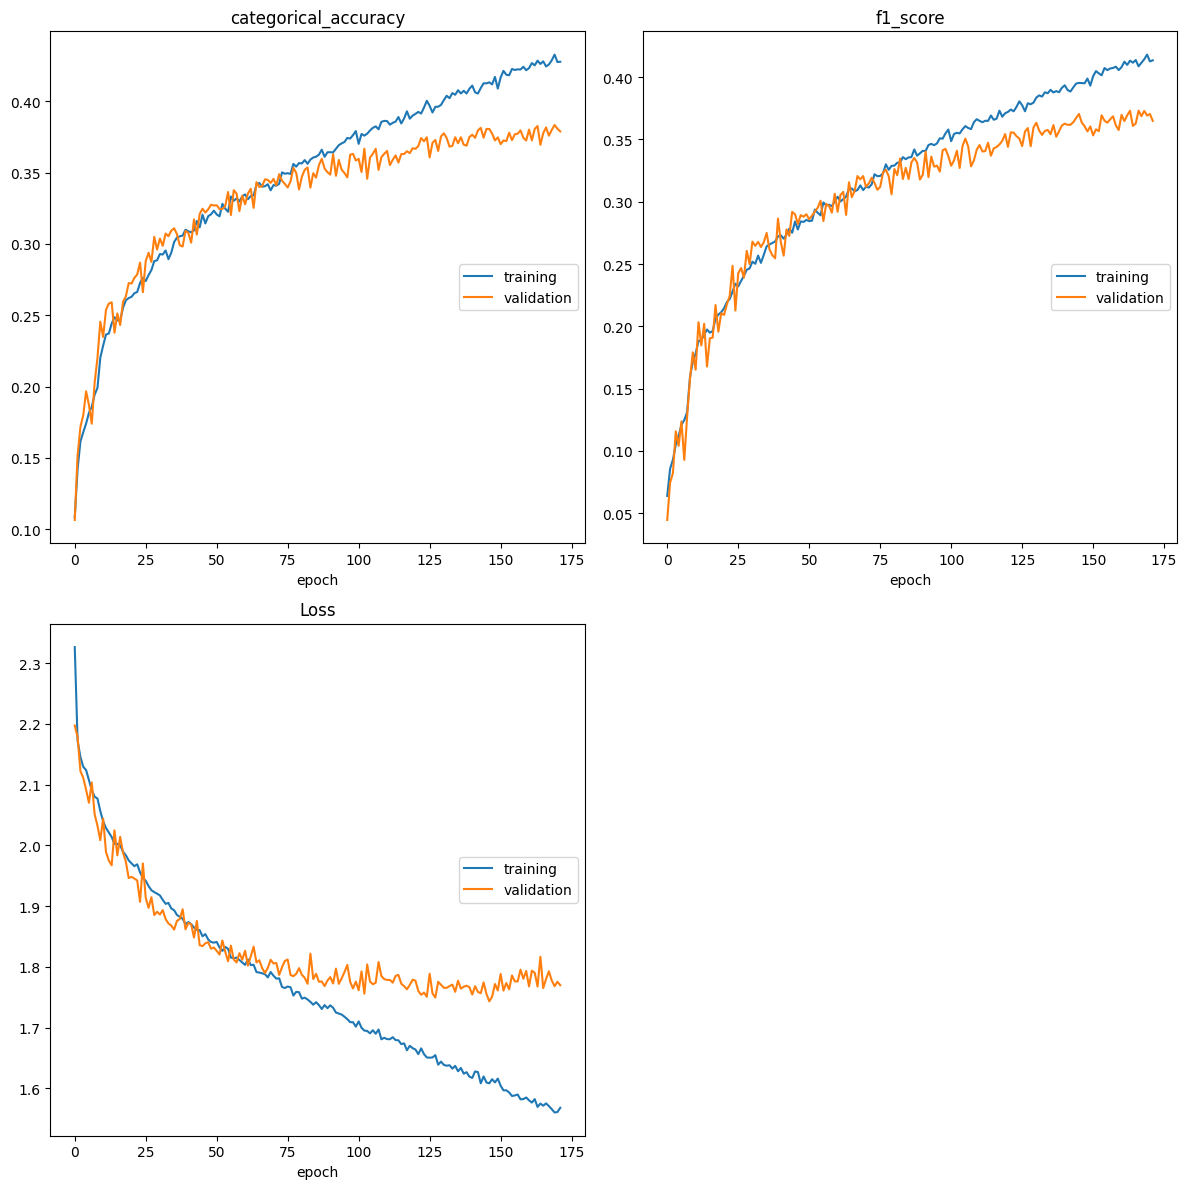

categorical_accuracy
	training         	 (min:    0.108, max:    0.433, cur:    0.428)
	validation       	 (min:    0.106, max:    0.383, cur:    0.379)
f1_score
	training         	 (min:    0.064, max:    0.418, cur:    0.413)
	validation       	 (min:    0.045, max:    0.373, cur:    0.365)
Loss
	training         	 (min:    1.560, max:    2.326, cur:    1.568)
	validation       	 (min:    1.743, max:    2.197, cur:    1.770)

Epoch 172: val_categorical_accuracy did not improve from 0.38340

Epoch 172: val_f1_score did not improve from 0.37314
Restoring model weights from the end of the best epoch: 147.
250/250 [==============================] - 140s 558ms/step - loss: 1.5680 - categorical_accuracy: 0.4277 - f1_score: 0.4135 - val_loss: 1.7699 - val_categorical_accuracy: 0.3789 - val_f1_score: 0.3649 - lr: 2.6572e-04
Epoch 172: early stopping
CPU times: user 8h 6min 13s, sys: 2h 42min 58s, total: 10h 49min 12s
Wall time: 6h 42min 25s


In [19]:
%%time


history = model.fit_generator(
    train_generator,
    epochs=500,
    steps_per_epoch=250,
    validation_steps=100,
    validation_data=validation_generator,
    callbacks=[plot_progress, acc_checkpoint, f1_checkpoint, stopper, reduce_lr],
    verbose = True)

### Посмотрим, что у нас по итогу получилось:

In [13]:
#Для проверки качества моделей нужно импортировать метрику f1
import tensorflow_addons as tfa
f1 =tfa.metrics.F1Score(num_classes=9, average='weighted')

/home/nette/miniconda3/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [14]:
#Загрузим модели из чекпойнтов
model_acc = tf.keras.models.load_model("checkpoints/emotion_recog/acc_2blocks.h5")
model_f1 = tf.keras.models.load_model("checkpoints/emotion_recog/f1_2blocks.h5")

In [15]:
#Проверка текущих результатов:
model_acc.evaluate(validation_generator)

101/101 [==============================] - 23s 214ms/step - loss: 1.7686 - categorical_accuracy: 0.3831 - f1_score: 0.3691


[1.7686008214950562, 0.38313180208206177, 0.36909419298171997]

In [16]:
model_f1.evaluate(validation_generator)

101/101 [==============================] - 22s 209ms/step - loss: 1.7802 - categorical_accuracy: 0.3817 - f1_score: 0.3732


[1.7801746129989624, 0.3817327916622162, 0.3732267916202545]

Как мы видим, точность модели повысилась примерно на 0.8% по сравнению с изначальным вариантом, что немного печально. Посмотрим что в итоге с остальными результатами. Удалось ли нам немного поменять ситуацию с точностью предсказания миноритарных классов?

4/4 [==============================] - 1s 72ms/step


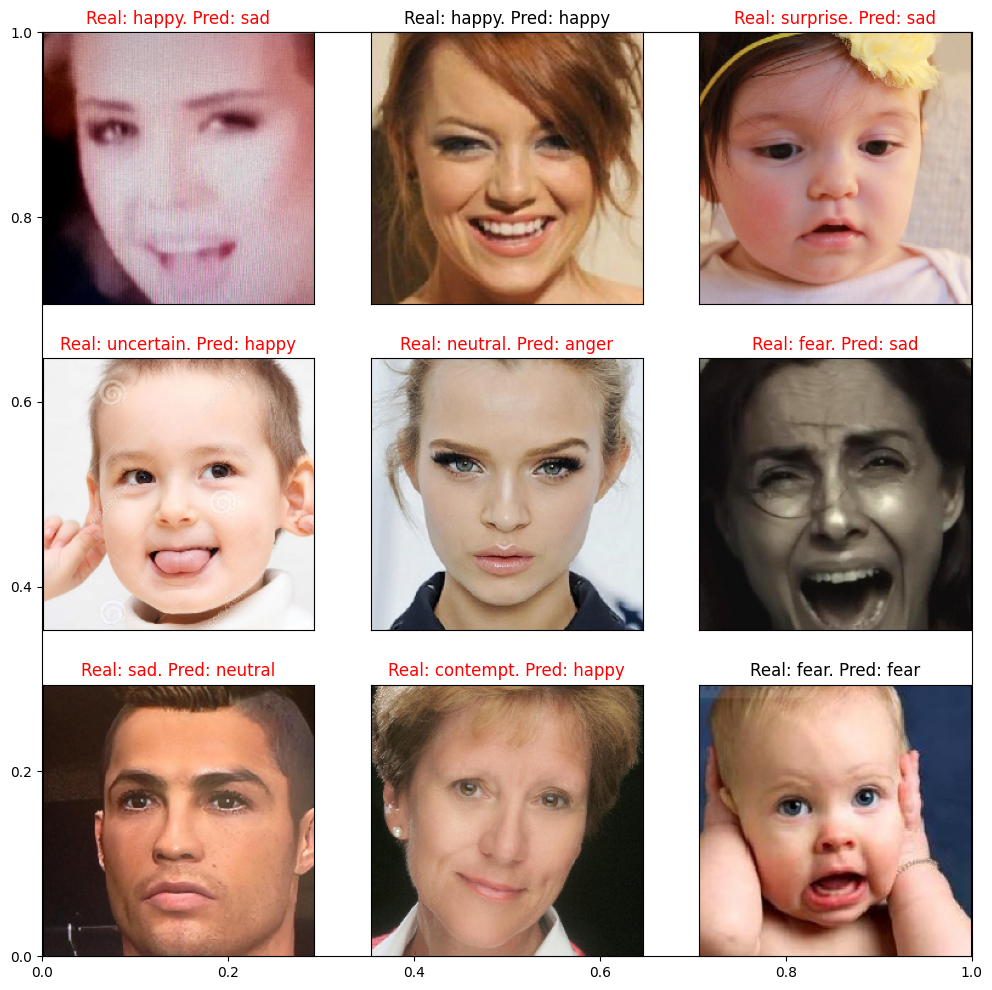

In [17]:
#Предсказание на батче изображений:
predicted = model_acc.predict(sample_validation_images).argmax(axis=1)
show_images_preds(sample_validation_images, sample_validation_labels, predicted)

4/4 [==============================] - 1s 72ms/step


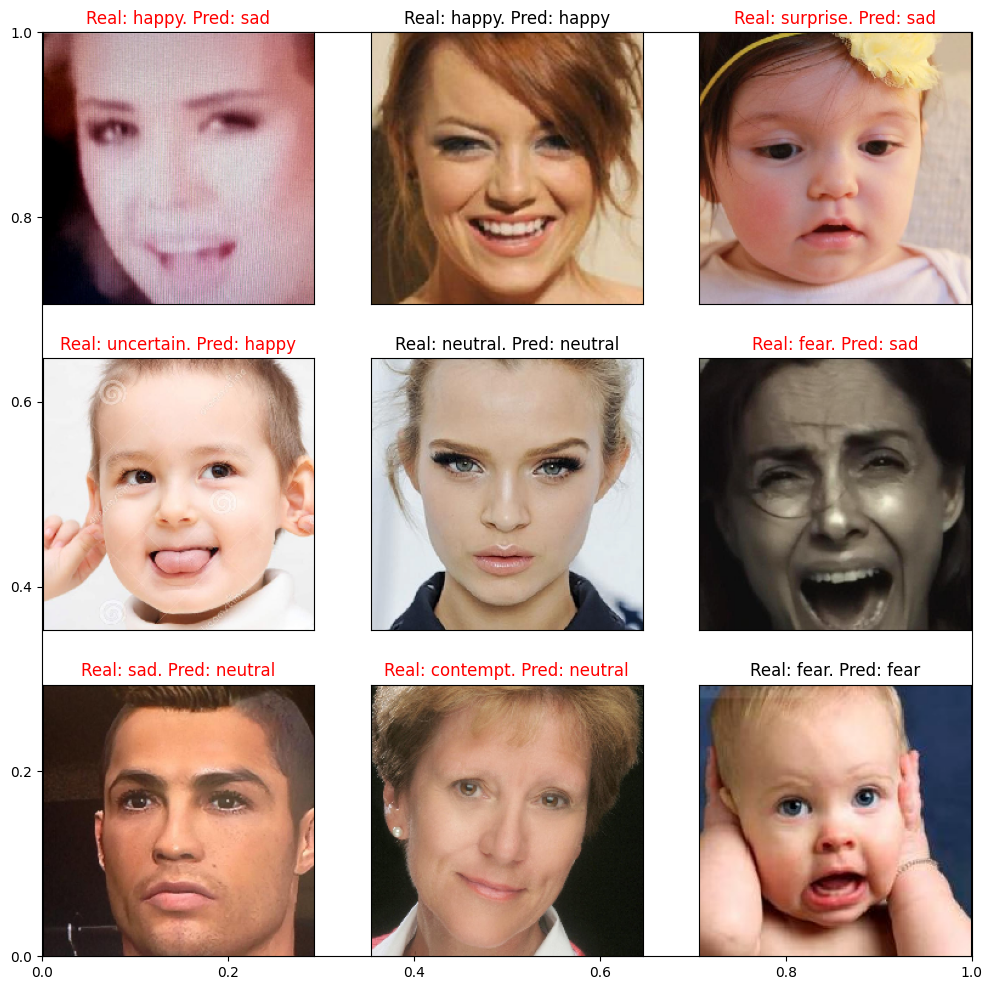

In [18]:
#Для f1:
predicted = model_f1.predict(sample_validation_images).argmax(axis=1)
show_images_preds(sample_validation_images, sample_validation_labels, predicted)

In [19]:
#Предсказание для всего валидационного сета для дальнейшей оценки результатов:
predict_val_acc_probs = model_acc.predict(validation_generator)
predict_val_f1_probs = model_f1.predict(validation_generator)
predict_val_acc = np.argmax(predict_val_acc_probs, axis = 1)
predict_val_f1 = np.argmax(predict_val_f1_probs, axis = 1)

101/101 [==============================] - 22s 212ms/step


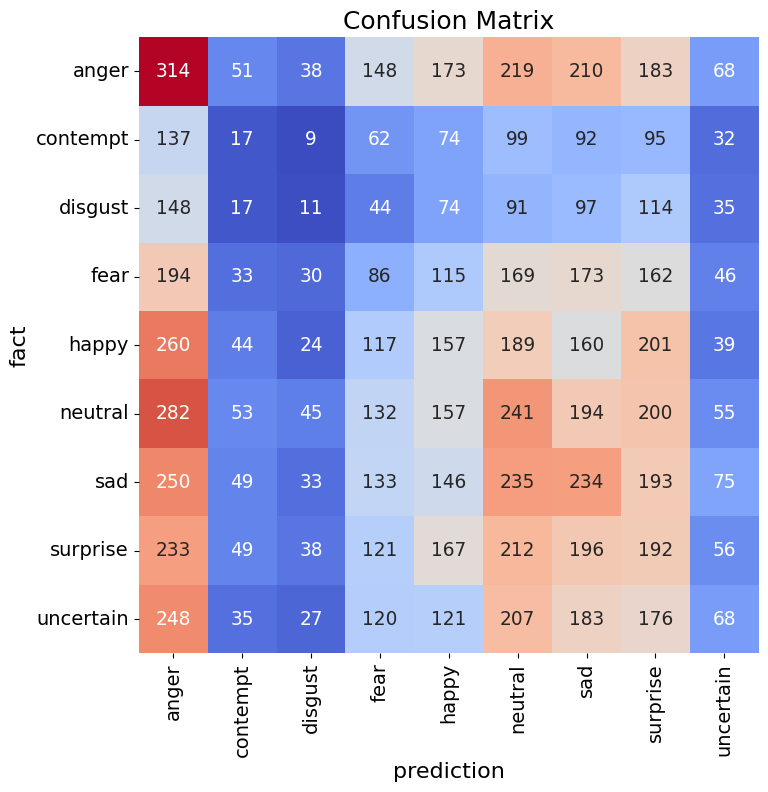

In [20]:
#Матрица ошибок для модели с акцентом на accuracy
show_conf_matrix(y_test, predict_val_acc)

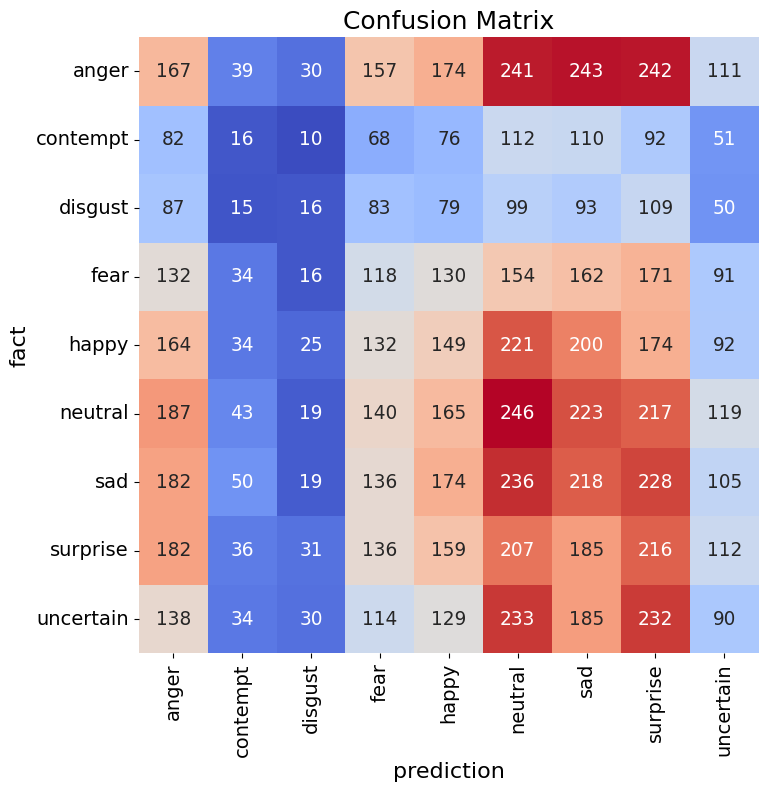

In [21]:
#Матрица ошибок для модели с акцентом на f1-score
show_conf_matrix(y_test, predict_val_f1)

In [22]:
#И classification report для "accuracy based" модели:
names = list(train_generator.class_indices.keys())
print(classification_report(y_test, predict_val_acc, target_names=names))

              precision    recall  f1-score   support

       anger       0.15      0.22      0.18      1404
    contempt       0.05      0.03      0.04       617
     disgust       0.04      0.02      0.02       631
        fear       0.09      0.09      0.09      1008
       happy       0.13      0.13      0.13      1191
     neutral       0.15      0.18      0.16      1359
         sad       0.15      0.17      0.16      1348
    surprise       0.13      0.15      0.14      1264
   uncertain       0.14      0.06      0.08      1185

    accuracy                           0.13     10007
   macro avg       0.11      0.12      0.11     10007
weighted avg       0.12      0.13      0.12     10007



In [23]:
#Наконец, для "f1-score based" модели:
print(classification_report(y_test, predict_val_f1, target_names=names))

              precision    recall  f1-score   support

       anger       0.13      0.12      0.12      1404
    contempt       0.05      0.03      0.03       617
     disgust       0.08      0.03      0.04       631
        fear       0.11      0.12      0.11      1008
       happy       0.12      0.13      0.12      1191
     neutral       0.14      0.18      0.16      1359
         sad       0.13      0.16      0.15      1348
    surprise       0.13      0.17      0.15      1264
   uncertain       0.11      0.08      0.09      1185

    accuracy                           0.12     10007
   macro avg       0.11      0.11      0.11     10007
weighted avg       0.12      0.12      0.12     10007



**Выводы:** Интересно, выходит, что при условии обучения в одном цикле и при одинаковой структуре модели с одинаковыми изначальными весами можно получить немного разные модели, лишь сместив внимание с одной метрики на другую. В целом, accuracy-based модель лучше предсказывает гнев, презрение, радость печаль, а f1-based модель лучше справляется с отвращением, испугом, удивление и неопределенность. Отсюда возникает вопрос: можно ли как-то объединить эти модели для более сбалансированного по классам предсказания?

Для начала попробуем влоб объединить результаты пресказаний двух моделей. Самый лучший результат получился методом ниже (ссылку на подробное описание см.ниже).

*Источник: https://www.aiproblog.com/index.php/2018/12/27/how-to-develop-a-weighted-average-ensemble-for-deep-learning-neural-networks/*

In [24]:
#Объединим предсказания моделей
#Во-первых, соберем все предсказания в один массив:
val_predictions = []
val_predictions.append(predict_val_acc_probs)
val_predictions.append(predict_val_f1_probs)
val_predictions = np.array(val_predictions)

In [25]:
# Ф-ция для нормализации вектора весов
#По сути мы будем использовать её, чтобы генерировать пары весов, в сумме дающих единицу (т.е. 100%)
def normalize(weights):
    # вычмсление l1-нормы
    result = np.linalg.norm(weights, 1)
    # Если результат равен 0, то веса выведем в неизменном виде
    if result == 0.0:
        return weights
    #В противном случае, выведем нормализованный вектор
    return weights / result

In [26]:
#Функция для перебора пар весов из заданного диапазона для поиска тех, что дают наилучший результат по выбранной метрике:
#На вход принимает предсказания, правильные метки классов, к-во моделей для поиска весов, границы поиска весов и шаг между ними,
#метрику и способ усреднения для f1-метрики.
def grid_search(predictions, y_true, models_cnt = 2, w_min = 0, w_max = 1.05, step = 0.05, metric = 'f1', avg = 'weighted'):
    # Установим границы и шаг поиска:
    w = np.arange(w_min,w_max,step)
    best_score, best_weights = 0.0, None
    # Итерация по всем комбинациям весов в заданных выше пределах (декартово произведение)
    for weights in itertools.product(w, repeat=models_cnt):
        # Проверка на равенство весов
        if len(set(weights)) == 1:
            continue
        # воспользуемся ф-цией нормализации выше для подбора всех комбинаций
        weights = normalize(weights)
        # оценка весов
        summed = np.tensordot(predictions, weights, axes=((0),(0)))
        y_pred =  np.argmax(summed, axis=1)
        if metric == 'f1':
            score = sklearn.metrics.f1_score(y_true, y_pred, average = avg)
        elif metric == 'accuracy':
            score = sklearn.metrics.balanced_accuracy_score(y_true, y_pred)
        if score > best_score:
            best_score, best_weights = score, weights
            print('>%s %.5f' % (best_weights, best_score))
    return best_weights

In [27]:
weights = grid_search(val_predictions, y_true = y_test, w_max = 1.01, step = 0.01)

>[0. 1.] 0.11822
>[1. 0.] 0.12431
>[0.85714286 0.14285714] 0.12482
>[0.875 0.125] 0.12502
>[0.88888889 0.11111111] 0.12506
>[0.9 0.1] 0.12555
>[0.91666667 0.08333333] 0.12557
>[0.92 0.08] 0.12572
>[0.91891892 0.08108108] 0.12572
>[0.91803279 0.08196721] 0.12576


In [28]:
#Оценка резултата
summed = np.tensordot(val_predictions, weights, axes=((0),(0)))
val_result2 =  np.argmax(summed, axis=1)

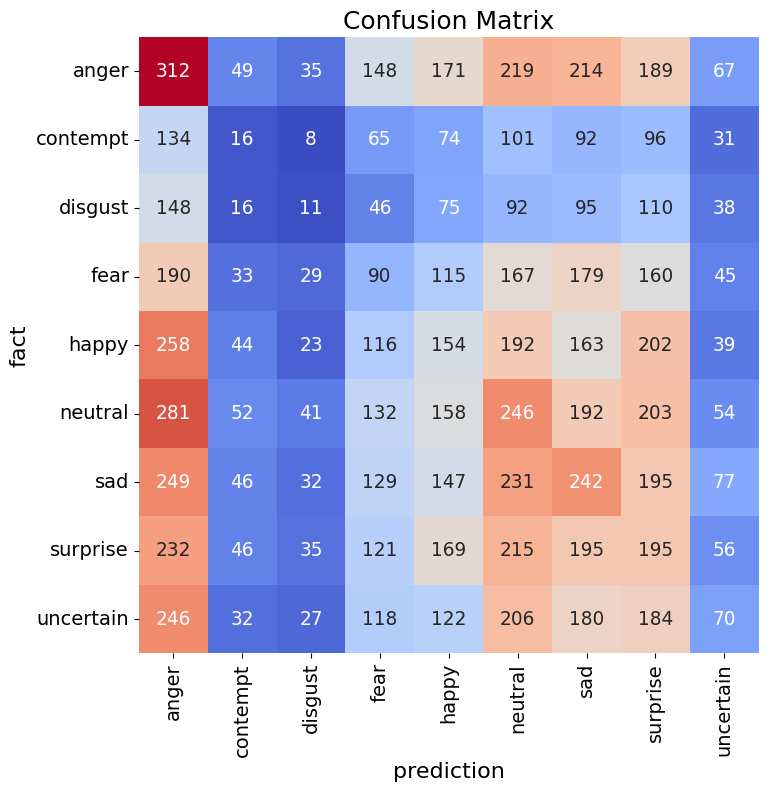

In [29]:
#Матрица ошибок
show_conf_matrix(y_test, val_result2)

In [30]:
#И classification report
print(classification_report(y_test, val_result2, target_names=names))

              precision    recall  f1-score   support

       anger       0.15      0.22      0.18      1404
    contempt       0.05      0.03      0.03       617
     disgust       0.05      0.02      0.03       631
        fear       0.09      0.09      0.09      1008
       happy       0.13      0.13      0.13      1191
     neutral       0.15      0.18      0.16      1359
         sad       0.16      0.18      0.17      1348
    surprise       0.13      0.15      0.14      1264
   uncertain       0.15      0.06      0.08      1185

    accuracy                           0.13     10007
   macro avg       0.12      0.12      0.11     10007
weighted avg       0.13      0.13      0.13     10007



Как мы видим, такое объединение позволило повысить взвешенный f1-score, чего мы, собственно, и добивались.

Ради интереса попробуем объединить модели посредством functional API. Модели можно было бы объединить простыми слоями Concatenate или Average, но, судя по предсказаниям выше, такой подход не совсем целесообразен. Поэтому придется повозиться с созданием кастомного взвешенного слоя.

In [31]:
#Для инициализации весов (сразу укажем наши оптимальные веса, найденные выше)
def weight_init(shape =(1,1,3), weights=[0.91803279, 0.08196721], dtype=tf.float32):
    return tf.constant(np.array(weights).reshape(shape), dtype=dtype)

In [32]:
#Напишем ф-цию для реализации слоя с весами, назовем слой WeightedAverage:
from tensorflow.keras.layers import Layer, Concatenate

class WeightedAverage(Layer):

    def __init__(self):
        super(WeightedAverage, self).__init__()
        
    def build(self, input_shape):
        
        self.W = self.add_weight(
                    shape=(1,1,len(input_shape)),
                    initializer=weight_init,
                    dtype=tf.float32,
                    trainable=True)
    def call(self, inputs):
    
        inputs = [tf.expand_dims(i, -1) for i in inputs]
        inputs = Concatenate(axis=-1)(inputs) 
        weights = tf.nn.softmax(self.W, axis=-1)

        return tf.reduce_mean(weights*inputs, axis=-1)

In [33]:
#Для объединения будем использовать только сам resnet, без учета Dense-слоёв и Input-слоя:
acc_model_resnet = model_acc.layers[0]
f1_model_resnet = model_f1.layers[0]
#Переименуем модель2, чтобы не было конфликтов в названиях дальше:
# first_model._name = 'resnet50v2_acc'
# second_model._name = 'resnet50v2_f1'

In [34]:
IMG_SHAPE = (224, 224, 3)
# базовая модель -- ResNet50V2
first_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)

first_model.set_weights(acc_model_resnet.get_weights()) 

second_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)
second_model.set_weights(f1_model_resnet.get_weights())
first_model._name = 'resnet50v2_acc'
second_model._name = 'resnet50v2_f1'
first_model.trainable = False
second_model.trainable = False

In [35]:
#Соберем объединенную модель с учетом слоя для взвешенного среднего
input = keras.Input(shape=(224, 224, 3))  # input

# output каждой модели (не забываем "замораживать" уже обученные модели)
x_in1 = first_model(input, training=False)
x_in2 = second_model(input, training=False)

#GlobalAveragePooling для выходов каждой модели
x_in1 = tf.keras.layers.GlobalAveragePooling2D()(x_in1)
x_in2 = tf.keras.layers.GlobalAveragePooling2D()(x_in2)


# Средневзвешенное по выходам (объединяем в один слой с учетом весов)
x = WeightedAverage()([x_in1,x_in2])
#И те же Dense-слои + слои регуляризации Dropout, чтобы исключить переобучение
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)

output = tf.keras.layers.Dense(9, activation='softmax')(x) # итоговый выход

weighted_avg_model = tf.keras.Model(input, output, name= 'Weighted_AVerage_Model')

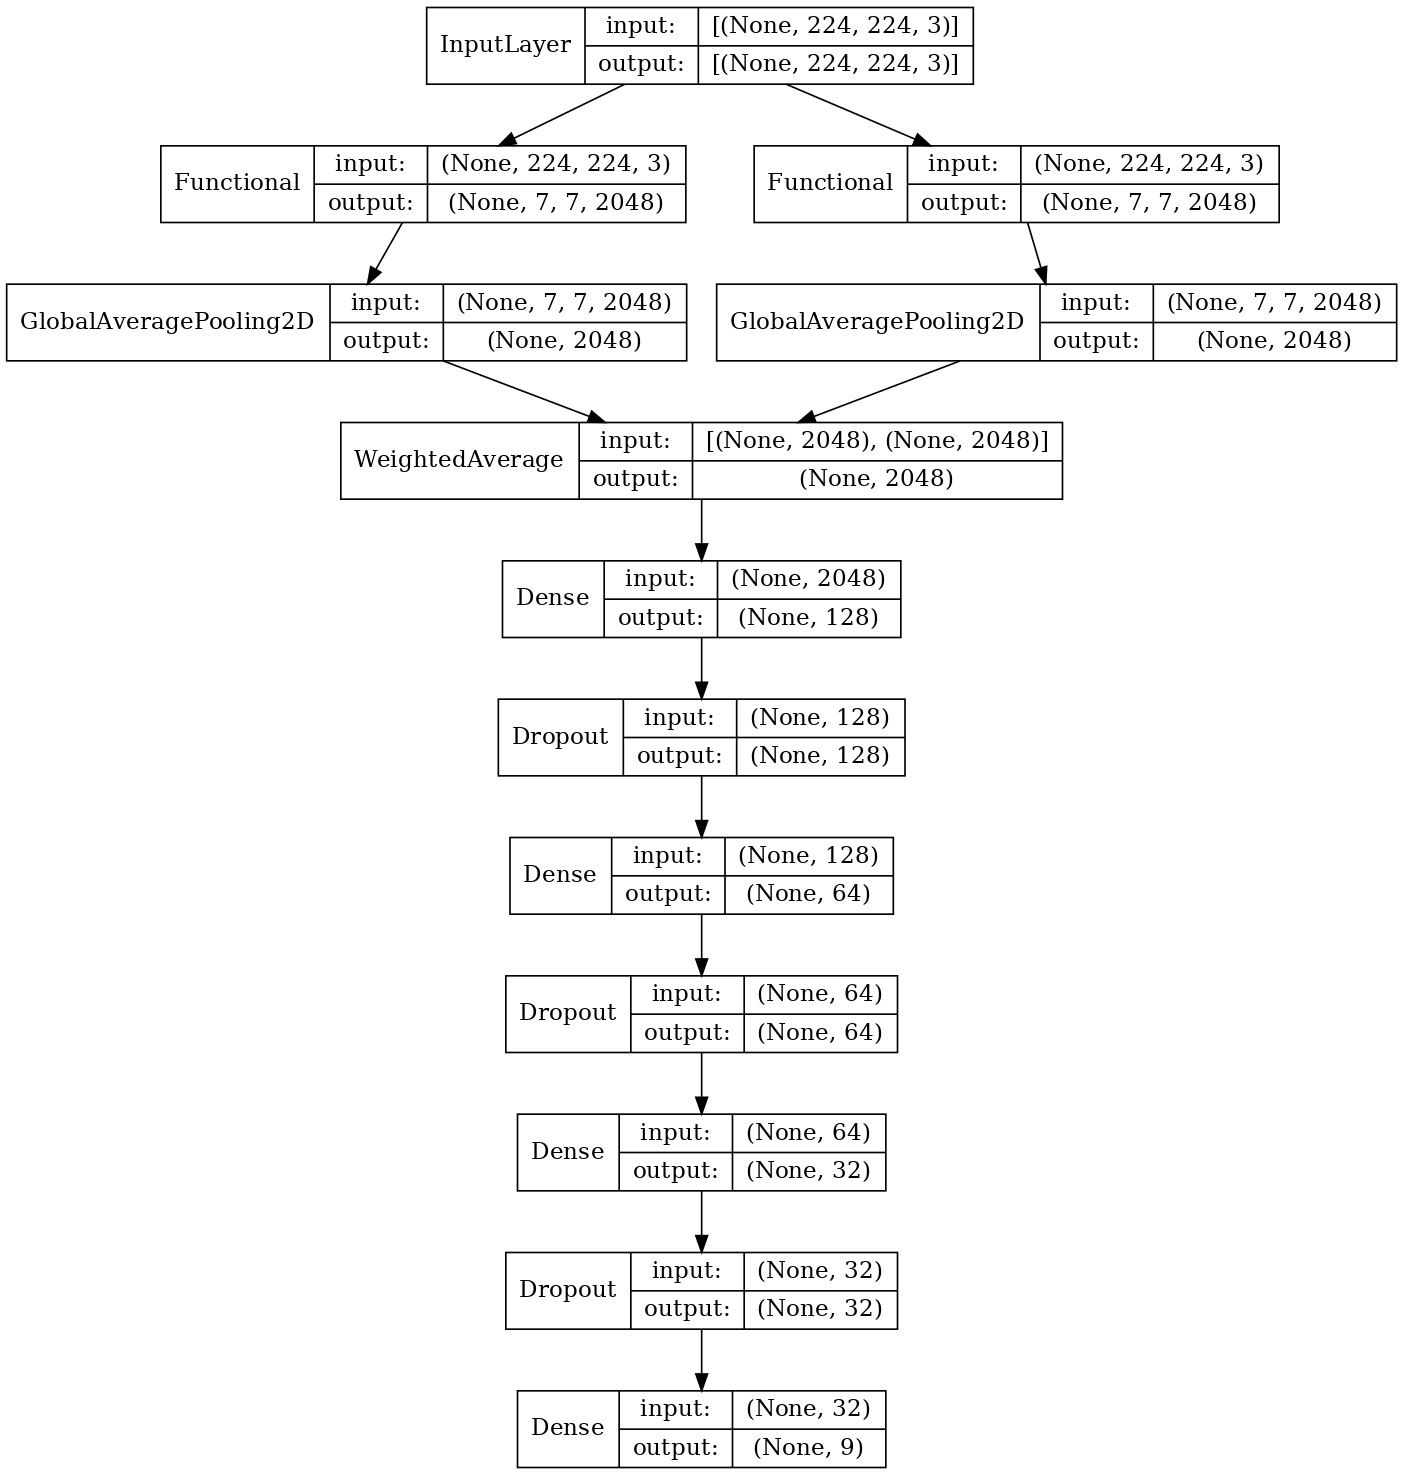

In [36]:
from tensorflow.keras.utils import plot_model
plot_model(weighted_avg_model, show_shapes=True, show_layer_names=False, dpi=120)

In [37]:
weighted_avg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy(), f1])

In [38]:
#Снова чекпойнты
plot_progress = PlotLossesCallback()
wavg_checkpoint = ModelCheckpoint('checkpoints/emotion_recog/weighted_avg_model.h5',monitor="val_categorical_accuracy",verbose=1,save_best_only=True,mode="max")
stopper = EarlyStopping(monitor = 'val_loss', verbose = 1, restore_best_weights=True, mode="min", patience = 2)
reduce_lr = ReduceLROnPlateau(monitor='val_f1_score', factor=0.9, patience=15, verbose=1, min_lr=0.00005)

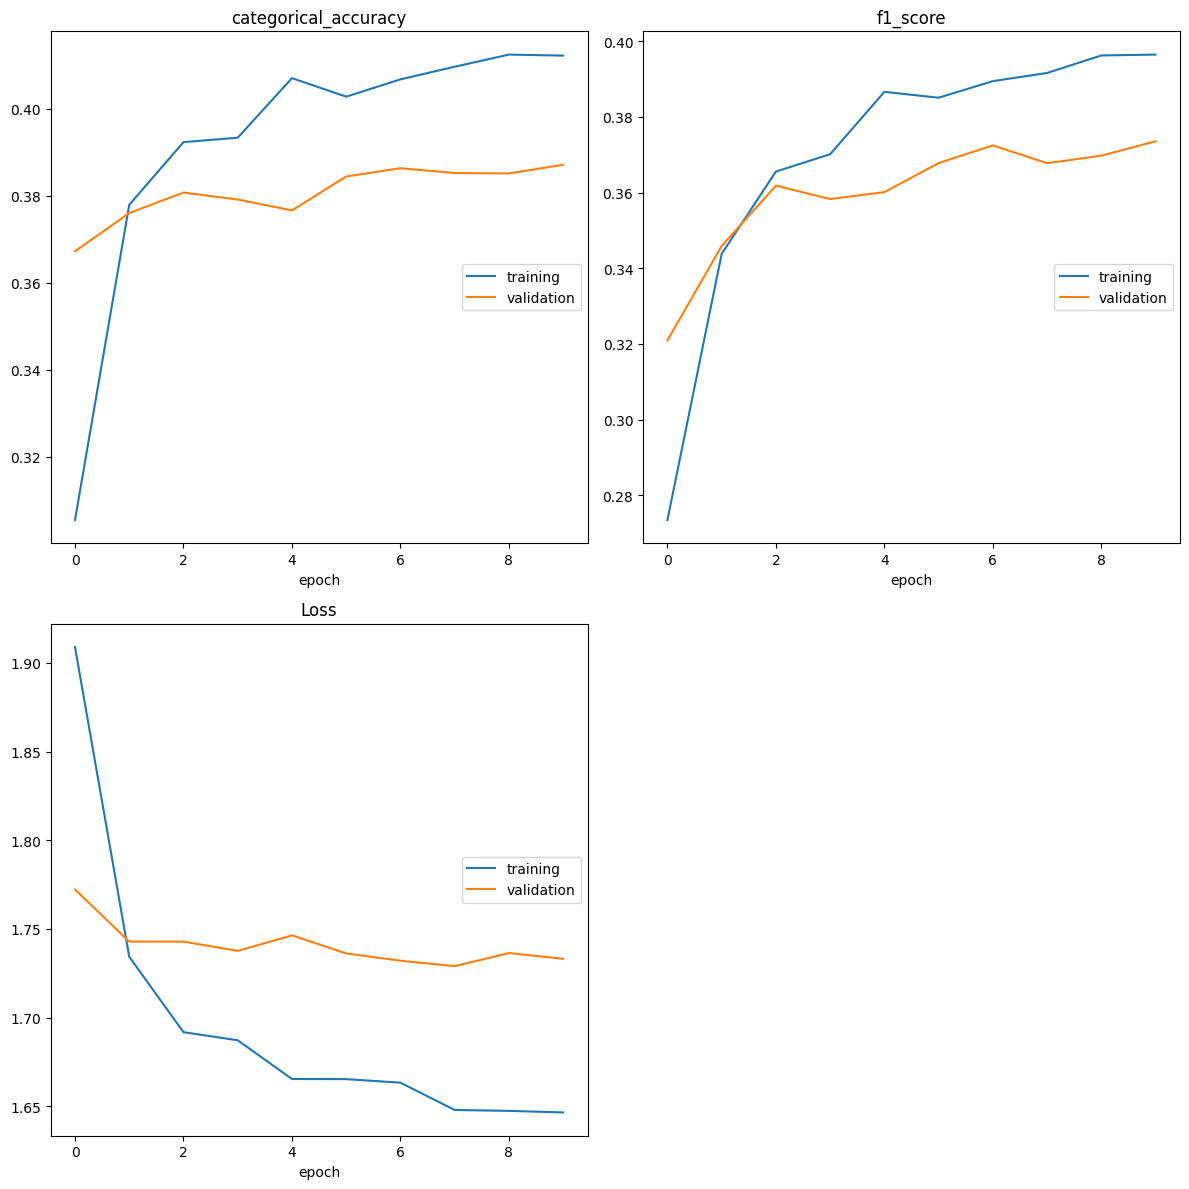

categorical_accuracy
	training         	 (min:    0.305, max:    0.412, cur:    0.412)
	validation       	 (min:    0.367, max:    0.387, cur:    0.387)
f1_score
	training         	 (min:    0.274, max:    0.396, cur:    0.396)
	validation       	 (min:    0.321, max:    0.374, cur:    0.374)
Loss
	training         	 (min:    1.647, max:    1.909, cur:    1.647)
	validation       	 (min:    1.729, max:    1.772, cur:    1.733)

Epoch 10: val_categorical_accuracy improved from 0.38630 to 0.38710, saving model to checkpoints/emotion_recog/weighted_avg_model.h5
Restoring model weights from the end of the best epoch: 8.
250/250 [==============================] - 159s 634ms/step - loss: 1.6466 - categorical_accuracy: 0.4122 - f1_score: 0.3965 - val_loss: 1.7332 - val_categorical_accuracy: 0.3871 - val_f1_score: 0.3736 - lr: 5.0000e-04
Epoch 10: early stopping
CPU times: user 30min 13s, sys: 17min 15s, total: 47min 28s
Wall time: 26min 32s


In [39]:
%%time


history_wm = weighted_avg_model.fit_generator(
    train_generator,
    epochs=100,
    steps_per_epoch=250,
    validation_steps=100,
    validation_data=validation_generator,
    callbacks=[plot_progress, wavg_checkpoint, stopper, reduce_lr],
    verbose = True)

In [40]:
predict_val_w_probs = weighted_avg_model.predict(validation_generator)
predict_val_w = np.argmax(predict_val_w_probs, axis = 1)

101/101 [==============================] - 43s 426ms/step


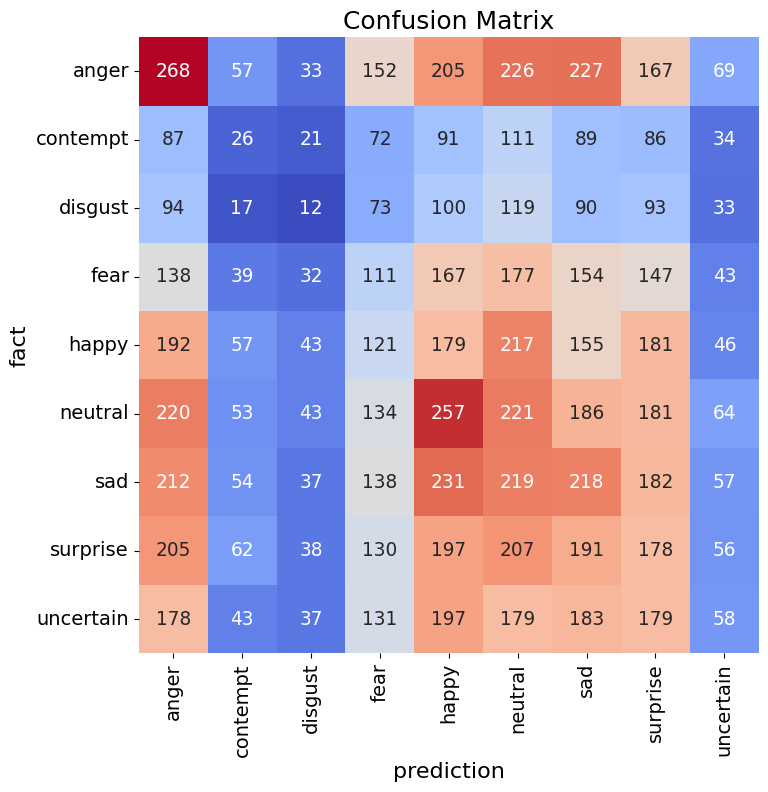

In [41]:
#Матрица ошибок для модели
show_conf_matrix(y_test, predict_val_w)

In [42]:
#И classification report
print(classification_report(y_test, predict_val_w, target_names=names))

              precision    recall  f1-score   support

       anger       0.17      0.19      0.18      1404
    contempt       0.06      0.04      0.05       617
     disgust       0.04      0.02      0.03       631
        fear       0.10      0.11      0.11      1008
       happy       0.11      0.15      0.13      1191
     neutral       0.13      0.16      0.15      1359
         sad       0.15      0.16      0.15      1348
    surprise       0.13      0.14      0.13      1264
   uncertain       0.13      0.05      0.07      1185

    accuracy                           0.13     10007
   macro avg       0.11      0.11      0.11     10007
weighted avg       0.12      0.13      0.12     10007



**Вывод:** модель быстро начала переобучаться, качество предсказаний при этом чуть упало по сравнению с простым объединением результатов моделей. Так что остановимся на предпоследней версии.

## Получение предсказаний итоговой модели

In [31]:
#Предсказания моделей сохраним в список model_predictions:
predict_result_acc = model_acc.predict(test_generator)
predict_result_f1 = model_f1.predict(test_generator)
model_predictions = []
model_predictions.append(predict_result_acc)
model_predictions.append(predict_result_f1)

50/50 [==============================] - 10s 208ms/step


In [32]:
#Сохраним в отдельный список названия файлов из датагена:
ids = []
for filename in test_generator.filenames:
    ids.append(filename.split('/')[1])

In [33]:
#Получим итоговое предсказание, сохраним его в список и выведем его первые 10 строк:
result = []
names = dict((v,k) for k,v in train_generator.class_indices.items())
model_predictions = np.array(model_predictions)
predictions = np.tensordot(model_predictions, weights, axes=((0),(0)))
for index, prediction in enumerate(predictions):
    pred = np.argmax(prediction)
    classes = names[pred]
    result.append([ids[index], classes])
result[:10]

[['0.jpg', 'fear'],
 ['1.jpg', 'neutral'],
 ['10.jpg', 'anger'],
 ['100.jpg', 'neutral'],
 ['1000.jpg', 'happy'],
 ['1001.jpg', 'surprise'],
 ['1002.jpg', 'contempt'],
 ['1003.jpg', 'sad'],
 ['1004.jpg', 'surprise'],
 ['1005.jpg', 'sad']]

Похоже, что экземпляры успешно предсказаны, но есть проблема с порядком отображения, т.к. формат названий файлов текстовый, а не числовой.

In [34]:
#Чтобы исправить это, сохраним в df и воспользуемся библиотекой natsort для сортировки:
res_df = pd.DataFrame(result, columns=['image_path','emotion'])
res_df.sort_values(by = 'image_path', inplace = True, key=natsort_keygen())
res_df.head(11)

image_path   emotion
0         0.jpg      fear
1         1.jpg   neutral
1112      2.jpg       sad
2223      3.jpg     anger
3334      4.jpg     anger
4445      5.jpg     anger
4556      6.jpg     anger
4667      7.jpg  surprise
4778      8.jpg      fear
4889      9.jpg     happy
2        10.jpg     anger